## Perspective API performance tests

Graph latency for a variety of different approaches to calling Perspective API:

- serial requests
- calling into production ranker 
- use of gather() vs TaskGroup
- minimal httpx 
- minimal aiohttp

In [48]:
from perspective_ranker import PerspectiveRanker, PERSPECTIVE_HOST, perspective_baseline_minus_outrage_toxic
import time
import logging
import requests
import os
import asyncio

logging.disable(logging.CRITICAL)
api_key = os.environ["PERSPECTIVE_API_KEY"]

In [49]:
# Ranking singleton, which is what the production code does
# In particular, this instantiates an httpx client singleton
pr = PerspectiveRanker()

# default attributes list
default_attributes = [x for x in perspective_baseline_minus_outrage_toxic] # strip weights 

In [50]:
# load sample data, resample to ensure 100 texts
import json
import random

with open("sample-request.json") as f:
    data = json.load(f)

texts = [item["text"] for item in data["items"] if item["text"] != ""]

while len(texts) < 100:
    texts.append(random.choice(texts))

In [51]:
# Measure avg time, stddev for an (async) function to run
async def average_latency(func, num_trials=20):
    times = []
    for i in range(0, num_trials):
        start_time = time.time()
        await func()
        times.append(time.time() - start_time)

    avg = sum(times) / len(times)
    stddev = (sum((x - avg) ** 2 for x in times) / len(times)) ** 0.5

    return avg, stddev


In [52]:
# Test latency of a single call
async def score_single_post(attributes=default_attributes):
    await pr.score(attributes, random.choice(texts), 0)


avg, stddev = await average_latency(score_single_post, 20)
print(f"Single call latency: {avg:.3f} ± {stddev:.3f}")


Single call latency: 0.158 ± 0.020


In [53]:
# Test single call latency using classic requests API
# This is to detect any overhead from httpx, our code, etc.
async def score_single_post_requests(attributes=default_attributes):
    headers = {"Content-Type": "application/json"}
    data = {
        "comment": {"text": random.choice(texts)},
        "languages": ["en"],
        "requestedAttributes": {attr: {} for attr in attributes},
    }

    requests.post(
        f"{PERSPECTIVE_HOST}/v1alpha1/comments:analyze?key={api_key}",
        json=data,
        headers=headers,
    )


avg, stddev = await average_latency(score_single_post_requests, 20)
print(f"Single call latency (requests API): {avg:.3f} ± {stddev:.3f}")

Single call latency (requests API): 0.195 ± 0.020


In [54]:
import matplotlib.pyplot as plt

latencies_50_posts = {}

# generic plotter
def plotme(title, x_value, y_values, stddevs, xlabel, ylabel):
    plt.errorbar(x_value, y_values, yerr=stddevs)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()


# chart latency vs. number of something
async def plot_latency(fn, n_values, title, xlabel, ylabel):
    latencies = []
    stddevs = []

    for n in n_values:
        print(f"Testing with {n} posts")

        avg, stddev = await average_latency(lambda: fn(n))
        latencies.append(avg)
        stddevs.append(stddev)

    if 50 in n_values:
        idx = n_values.index(50)
        la = latencies[idx]
        st = stddevs[idx]
        print(f"50 posts latency: {la:.3f} ± {st:.3f}")
        latencies_50_posts[title] = la
        title = title + f" -- {la:.3f} ± {st:.3f}"
        
    plotme(title, n_values, latencies, stddevs, xlabel, ylabel)

Testing with 25 posts
Testing with 50 posts
Testing with 75 posts
Testing with 100 posts
50 posts latency: 8.141 ± 0.089


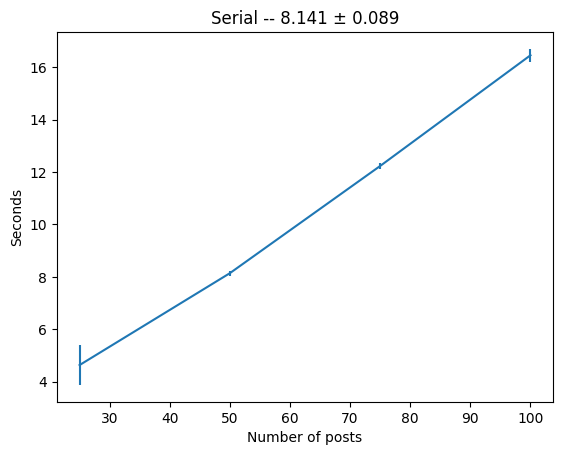

In [30]:
# Latency versus number of posts, serial
async def multiple_posts_serial(n):
    for _ in range(n):
        await score_single_post()


await plot_latency(
    multiple_posts_serial,
    range(25, 101, 25),
    "Serial",
    "Number of posts",
    "Seconds",
)


Testing with 10 posts
Testing with 20 posts
Testing with 30 posts
Testing with 40 posts
Testing with 50 posts
Testing with 60 posts
Testing with 70 posts
Testing with 80 posts
Testing with 90 posts
Testing with 100 posts
50 posts latency: 0.231 ± 0.022


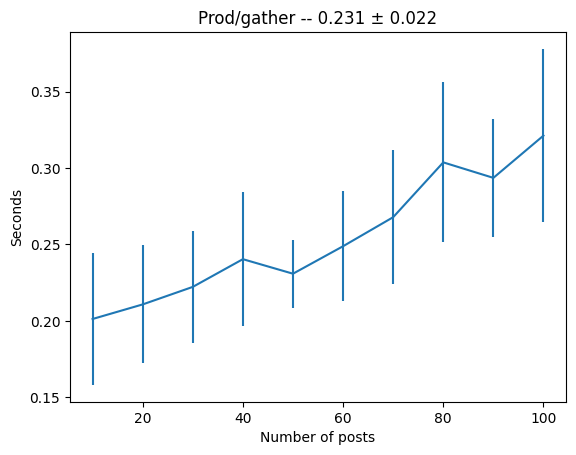

In [55]:
# Latency vs. number of posts, parallel with gather
async def multiple_posts_gather(n, attributes=default_attributes):
    await asyncio.gather(
        *[pr.score(attributes, random.choice(texts), 0) for _ in range(n)]
    )

await plot_latency(
    multiple_posts_gather,
    range(10, 101, 10),
    "Prod/gather",
    "Number of posts",
    "Seconds",
)

Testing with 10 posts
Testing with 20 posts
Testing with 30 posts
Testing with 40 posts
Testing with 50 posts
Testing with 60 posts
Testing with 70 posts
Testing with 80 posts
Testing with 90 posts
Testing with 100 posts
50 posts latency: 0.223 ± 0.026


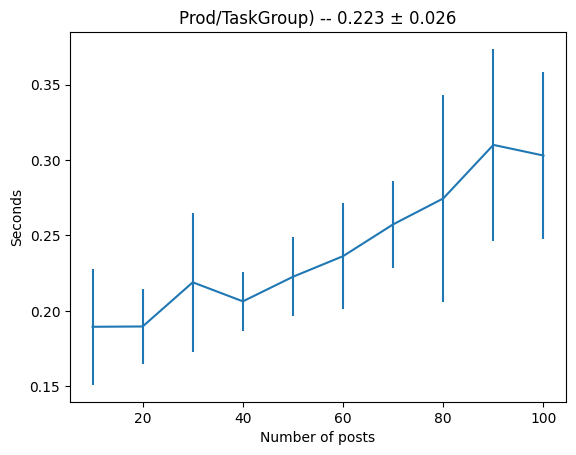

In [58]:
# Latency vs. number of posts, parallel with TaskGroup
async def multiple_posts_taskgroup(n, attributes=default_attributes):
    async with asyncio.TaskGroup() as task_group:
        for _ in range(n):
            task_group.create_task(pr.score(attributes, random.choice(texts), 0))


await plot_latency(
    multiple_posts_taskgroup,
    range(10, 101, 10),
    "Prod/TaskGroup",
    "Number of posts",
    "Seconds",
)


Testing with 10 posts
Testing with 20 posts
Testing with 30 posts
Testing with 40 posts
Testing with 50 posts
Testing with 60 posts
Testing with 70 posts
Testing with 80 posts
Testing with 90 posts
Testing with 100 posts
50 posts latency: 1.270 ± 2.433


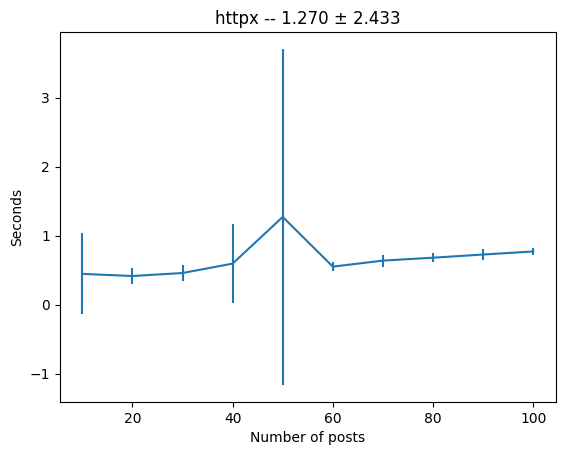

In [59]:
# Self-contained test, does not call into ranker code
# This should detect slowdowns from whatever in production implementation
import httpx

async def multiple_posts_httpx(n, attributes=default_attributes):
    async with httpx.AsyncClient(timeout=20) as client:
        requests = []
        for _ in range(n):
            requests.append(
                client.post(
                    f"{PERSPECTIVE_HOST}/v1alpha1/comments:analyze?key={api_key}",
                    json={
                        "comment": {"text": random.choice(texts)},
                        "languages": ["en"],
                        "requestedAttributes": {attr: {} for attr in attributes},
                    },
                    headers={"Content-Type": "application/json"},
                )
            )
        await asyncio.gather(*requests)


await plot_latency(
    multiple_posts_httpx,
    range(10, 101, 10),
    "httpx",
    "Number of posts",
    "Seconds",
)

Testing with 10 posts
Testing with 20 posts
Testing with 30 posts
Testing with 40 posts
Testing with 50 posts
Testing with 60 posts
Testing with 70 posts
Testing with 80 posts
Testing with 90 posts
Testing with 100 posts
50 posts latency: 0.486 ± 0.134


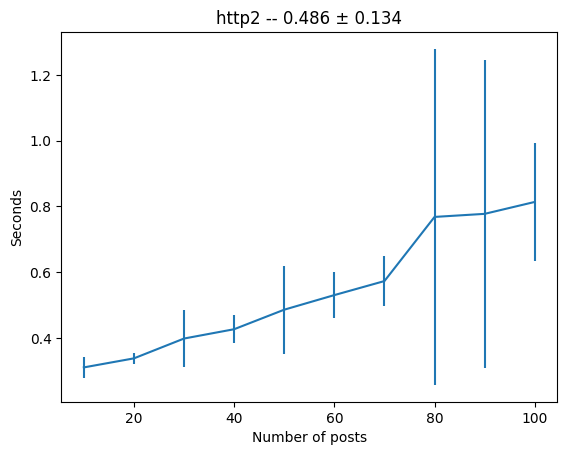

In [66]:
# http2 test

async def multiple_posts_http2(n, attributes=default_attributes):
    async with httpx.AsyncClient(http2=True, timeout=20) as client:
        requests = []
        for _ in range(n):
            requests.append(
                client.post(
                    f"{PERSPECTIVE_HOST}/v1alpha1/comments:analyze?key={api_key}",
                    json={
                        "comment": {"text": random.choice(texts)},
                        "languages": ["en"],
                        "requestedAttributes": {attr: {} for attr in attributes},
                    },
                    headers={"Content-Type": "application/json"},
                )
            )
        await asyncio.gather(*requests)


await plot_latency(
    multiple_posts_httpx,
    range(10, 101, 10),
    "http2",
    "Number of posts",
    "Seconds",
)

Testing with 10 posts
Testing with 20 posts
Testing with 30 posts
Testing with 40 posts
Testing with 50 posts
Testing with 60 posts
Testing with 70 posts
Testing with 80 posts
Testing with 90 posts
Testing with 100 posts
50 posts latency: 0.502 ± 0.052


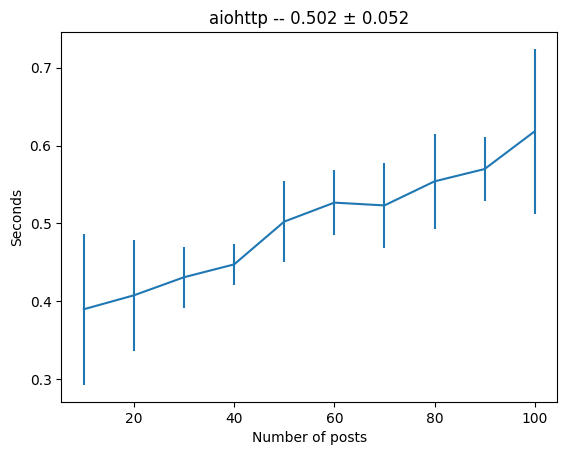

In [68]:
import aiohttp

async def multiple_posts_aiohttp(n, attributes=default_attributes):
    async def fetch_one():
        async with aiohttp.ClientSession() as session:
            async with session.post(
                    url=f"{PERSPECTIVE_HOST}/v1alpha1/comments:analyze?key={api_key}",
                    json={
                        "comment": {"text": random.choice(texts)},
                        "languages": ["en"],
                        "requestedAttributes": {attr: {} for attr in default_attributes},
                    },
                    headers={"Content-Type": "application/json"},
                ) as response:
                return await response.json()
            
    await asyncio.gather(*[fetch_one() for _ in range(n)])

await plot_latency(
    multiple_posts_aiohttp,
    range(10, 101, 10),
    "aiohttp",
    "Number of posts",
    "Seconds"
)

Testing with 10 posts
Testing with 20 posts
Testing with 30 posts
Testing with 40 posts
Testing with 50 posts
Testing with 60 posts
Testing with 70 posts
Testing with 80 posts
Testing with 90 posts
Testing with 100 posts
50 posts latency: 0.371 ± 0.038


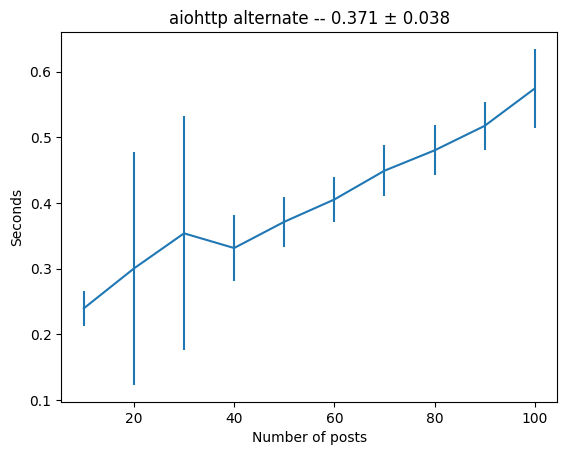

In [62]:
async def multiple_posts_aiohttp_alternate(n, attributes=default_attributes):
    async with aiohttp.ClientSession() as session:
        requests = []
        for _ in range(n):
            requests.append(
                session.post(
                    url=f"{PERSPECTIVE_HOST}/v1alpha1/comments:analyze?key={api_key}",
                    json={
                        "comment": {"text": random.choice(texts)},
                        "languages": ["en"],
                        "requestedAttributes": {attr: {} for attr in default_attributes},
                    },
                    headers={"Content-Type": "application/json"},
                )
            )
        await asyncio.gather(*requests)

await plot_latency(
    multiple_posts_aiohttp_alternate,
    range(10, 101, 10),
    "aiohttp alternate",
    "Number of posts",
    "Seconds"
)

Testing with 10 posts


/var/folders/8_/y3ps48r53bg0dg0cvx56yyl80000gn/T/ipykernel_68110/2747777694.py:19: RuntimeWarning: coroutine 'ClientSession.close' was never awaited
  cs.close()


Testing with 20 posts
Testing with 30 posts
Testing with 40 posts
Testing with 50 posts
Testing with 60 posts
Testing with 70 posts
Testing with 80 posts
Testing with 90 posts
Testing with 100 posts
50 posts latency: 0.217 ± 0.015


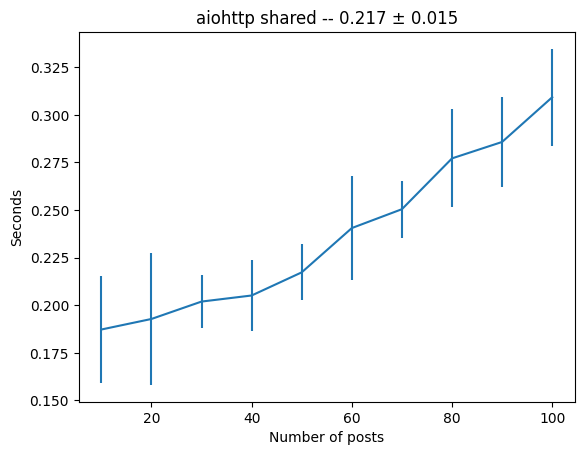

In [63]:
cs = aiohttp.ClientSession()

async def multiple_posts_aiohttp_shared(n, attributes=default_attributes):
    requests = []
    for _ in range(n):
        requests.append(
            cs.post(
                url=f"{PERSPECTIVE_HOST}/v1alpha1/comments:analyze?key={api_key}",
                json={
                    "comment": {"text": random.choice(texts)},
                    "languages": ["en"],
                    "requestedAttributes": {attr: {} for attr in default_attributes},
                },
                headers={"Content-Type": "application/json"},
            )
        )
    await asyncio.gather(*requests)

cs.close()

await plot_latency(
    multiple_posts_aiohttp_shared,
    range(10, 101, 10),
    "aiohttp shared",
    "Number of posts",
    "Seconds"
)

Testing with 10 posts


/var/folders/8_/y3ps48r53bg0dg0cvx56yyl80000gn/T/ipykernel_68110/3687488711.py:20: RuntimeWarning: coroutine 'ClientSession.close' was never awaited
  cs.close()


Testing with 20 posts
Testing with 30 posts
Testing with 40 posts
Testing with 50 posts
Testing with 60 posts
Testing with 70 posts
Testing with 80 posts
Testing with 90 posts
Testing with 100 posts
50 posts latency: 0.227 ± 0.021


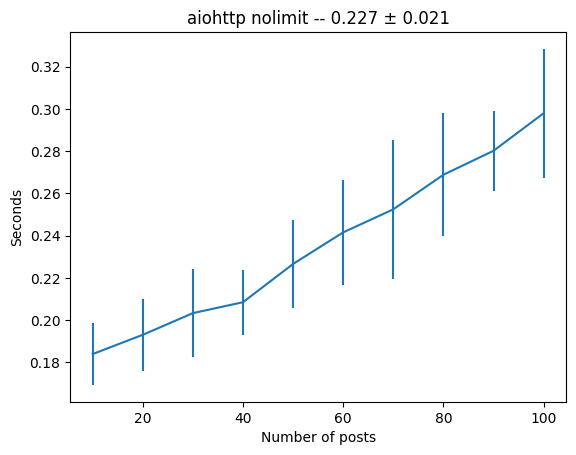

In [64]:
conn = aiohttp.TCPConnector(limit=0)
cs = aiohttp.ClientSession(connector=conn)

async def multiple_posts_aiohttp_shared_nolimit(n, attributes=default_attributes):
    requests = []
    for _ in range(n):
        requests.append(
            cs.post(
                url=f"{PERSPECTIVE_HOST}/v1alpha1/comments:analyze?key={api_key}",
                json={
                    "comment": {"text": random.choice(texts)},
                    "languages": ["en"],
                    "requestedAttributes": {attr: {} for attr in default_attributes},
                },
                headers={"Content-Type": "application/json"},
            )
        )
    await asyncio.gather(*requests)

cs.close()

await plot_latency(
    multiple_posts_aiohttp_shared_nolimit,
    range(10, 101, 10),
    "aiohttp nolimit",
    "Number of posts",
    "Seconds"
)

In [69]:
for k in latencies_50_posts:
    print(f"{k:20} {latencies_50_posts[k]:.3f}")

Prod/gather          0.231
Prod/TaskGroup)      0.223
httpx                1.270
http2                0.486
aiohttp              0.502
aiohttp alternate    0.371
aiohttp shared       0.217
aiohttp nolimit      0.227
